## Import Required Libraries

In [ ]:
#%pip install qiskit==0.44.0
#%pip install qiskit-aer==0.12.0
#%pip install qiskit-machine-learning==0.6.0
#%pip install scikit-learn==1.0.2
#%pip install pandas numpy matplotlib seaborn
#%pip show scikit-learn

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from qiskit_aer import Aer
from qiskit.circuit.library import TwoLocal
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.algorithms import VQC, QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc


In [70]:
# Load your dataset
full_df = pd.read_csv('heart.csv')  # Replace with your dataset

# Randomly sample 300 rows
df = full_df.sample(n=300, random_state=42)  # random_state ensures reproducibility

# Save the sampled dataset (optional)
#df.to_csv('sampled_heart.csv', index=False)

Dataset Attributes

1. **Age:** The age of the patient in years.
2. **Sex:** The gender of the patient.  
   - `M`: Male  
   - `F`: Female  
3. **ChestPainType:** Type of chest pain the patient experienced.  
   - `TA`: Typical Angina (chest pain due to reduced blood flow)  
   - `ATA`: Atypical Angina (less common, more vague symptoms)  
   - `NAP`: Non-Anginal Pain (pain not related to heart issues)  
   - `ASY`: Asymptomatic (no chest pain)  
4. **RestingBP:** The patient’s resting blood pressure in mm Hg.
5. **Cholesterol:** The patient’s serum cholesterol level in mg/dl.
6. **FastingBS:** Fasting blood sugar level.  
   - `1`: Fasting blood sugar > 120 mg/dl  
   - `0`: Fasting blood sugar ≤ 120 mg/dl  
7. **RestingECG:** Results of the patient's resting electrocardiogram.  
   - `Normal`: Normal ECG  
   - `ST`: ST-T wave abnormality (e.g., T-wave inversions or ST elevation/depression)  
   - `LVH`: Left ventricular hypertrophy (thickening of the heart muscle)  
8. **MaxHR:** Maximum heart rate achieved by the patient during exercise (numeric value between 60 and 202).
9. **ExerciseAngina:** Whether the patient experienced exercise-induced chest pain.  
   - `Y`: Yes  
   - `N`: No  
10. **Oldpeak:** Depression in the ST segment during exercise (numeric value).
11. **ST_Slope:** The slope of the ST segment during peak exercise.  
   - `Up`: Upsloping  
   - `Flat`: Flat  
   - `Down`: Downsloping  
12. **HeartDisease:** Target variable indicating whether the patient has heart disease.  
   - `1`: Heart disease present  
   - `0`: No heart disease  

---

In [71]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
668,63,F,ATA,140,195,0,Normal,179,N,0.0,Up,0
30,53,M,NAP,145,518,0,Normal,130,N,0.0,Flat,1
377,65,M,ASY,160,0,1,ST,122,N,1.2,Flat,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1
807,54,M,ATA,108,309,0,Normal,156,N,0.0,Up,0


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 668 to 28
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             300 non-null    int64  
 1   Sex             300 non-null    object 
 2   ChestPainType   300 non-null    object 
 3   RestingBP       300 non-null    int64  
 4   Cholesterol     300 non-null    int64  
 5   FastingBS       300 non-null    int64  
 6   RestingECG      300 non-null    object 
 7   MaxHR           300 non-null    int64  
 8   ExerciseAngina  300 non-null    object 
 9   Oldpeak         300 non-null    float64
 10  ST_Slope        300 non-null    object 
 11  HeartDisease    300 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 30.5+ KB


In [73]:
# Show Shape of Data
print(f"Number of Rows : {df.shape[0]}\nNumber of Columns : {df.shape[1]}")

Number of Rows : 300
Number of Columns : 12


In [74]:
# check for null values
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [75]:
# describe the statistics of numeric data

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,300.0,53.363333,9.123346,28.0,47.75,54.0,60.00,76.0
RestingBP,300.0,131.243333,18.257288,80.0,120.00,130.0,140.00,200.0
Cholesterol,300.0,192.383333,116.160495,0.0,158.25,221.0,263.00,564.0
FastingBS,300.0,0.270000,0.444701,0.0,0.00,0.0,1.00,1.0
MaxHR,300.0,137.236667,26.910865,60.0,120.00,138.0,157.25,202.0
Oldpeak,300.0,0.835333,0.967715,-1.1,0.00,0.6,1.50,4.0
HeartDisease,300.0,0.593333,0.492032,0.0,0.00,1.0,1.00,1.0


- No null values present in the data

In [76]:
df.describe(include='object').T

,count,unique,top,freq
Sex,300,2,M,249
ChestPainType,300,4,ASY,153
RestingECG,300,3,Normal,184
ExerciseAngina,300,2,N,183
ST_Slope,300,3,Flat,140


In [77]:
# check duplication

df.duplicated().sum()

np.int64(0)

**Outliers Detection**

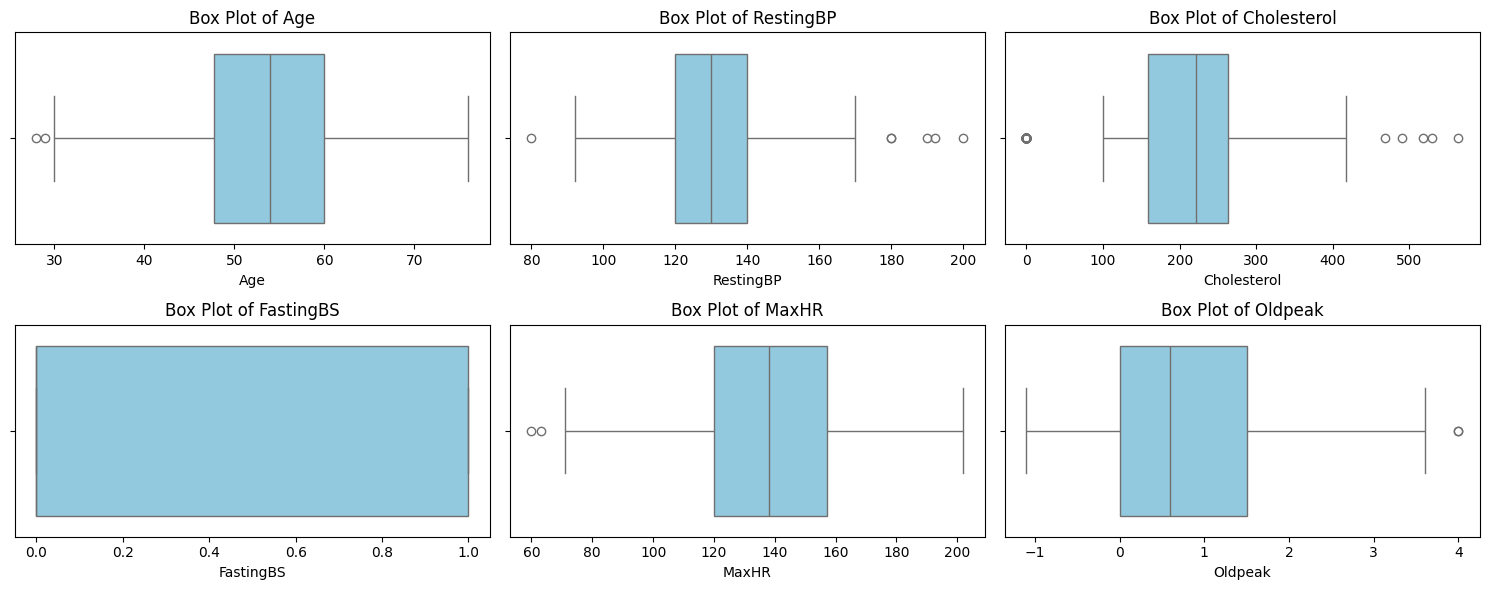

In [11]:
numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

plt.figure(figsize=(15, 6))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)  
    sns.boxplot(x = df[col], color = "skyblue")
    plt.title(f"Box Plot of {col}")

plt.tight_layout() 
plt.show()

In [78]:
# to find exactly in numbers

def detect_outliers_iqr(df, columns, threshold = 1.5):

    outlier_indices = {}

    for col in columns:
        Q1 = df[col].quantile(0.25)           # 25th percentile
        Q3 = df[col].quantile(0.75)           # 75th percentile
        IQR = Q3 - Q1                         # Interquartile range
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Finding outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()
        outlier_indices[col] = outliers
    
    return outlier_indices

outliers_iqr = detect_outliers_iqr(df, numerical_columns)

for col, indices in outliers_iqr.items():
    print(f"{col}: {len(indices)} outliers detected")

Age: 2 outliers detected
RestingBP: 6 outliers detected
Cholesterol: 69 outliers detected
FastingBS: 0 outliers detected
MaxHR: 2 outliers detected
Oldpeak: 2 outliers detected


In [79]:
def remove_outliers(df, columns, threshold=1.5):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)      # First quartile (25%)
        Q3 = df_clean[col].quantile(0.75)      # Third quartile (75%)
        IQR = Q3 - Q1                          # Interquartile range
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        df_clean = df_clean[(df_clean[col] > lower_bound) & (df_clean[col] < upper_bound)]
    
    return df_clean

df_cleaned = remove_outliers(df, numerical_columns)

# The New of Shape Cleaned Data
print(f"Number of Row : {df_cleaned.shape[0]}")


df = df_cleaned

Number of Row : 280


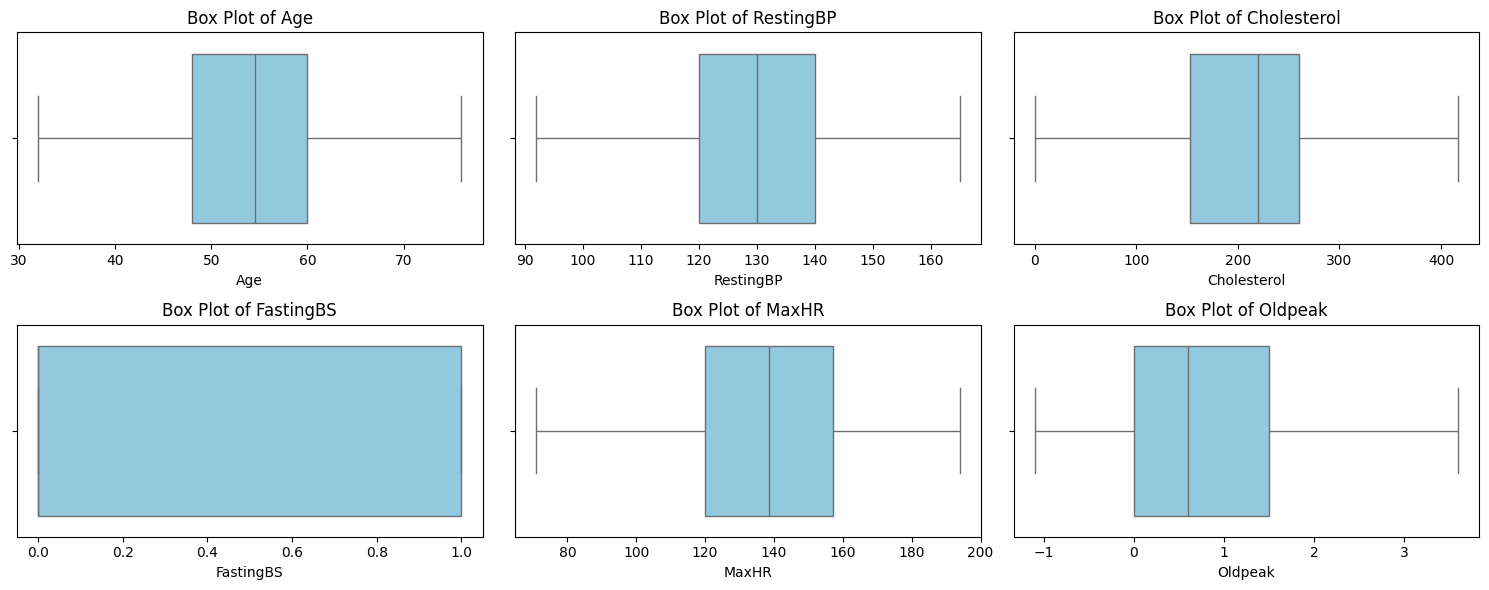

In [80]:
plt.figure(figsize=(15, 6))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i) 
    sns.boxplot(x = df[col], color = "skyblue")
    plt.title(f"Box Plot of {col}")

plt.tight_layout()
plt.show()

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 280 entries, 668 to 164
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             280 non-null    int64  
 1   Sex             280 non-null    object 
 2   ChestPainType   280 non-null    object 
 3   RestingBP       280 non-null    int64  
 4   Cholesterol     280 non-null    int64  
 5   FastingBS       280 non-null    int64  
 6   RestingECG      280 non-null    object 
 7   MaxHR           280 non-null    int64  
 8   ExerciseAngina  280 non-null    object 
 9   Oldpeak         280 non-null    float64
 10  ST_Slope        280 non-null    object 
 11  HeartDisease    280 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 28.4+ KB


## Exploratory Data Analysis

<Axes: xlabel='Age', ylabel='Count'>

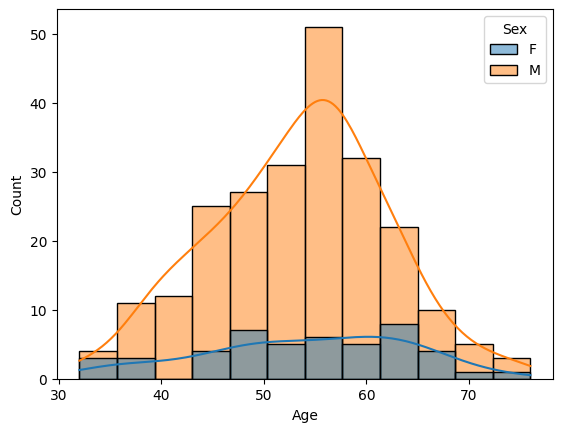

In [16]:
sns.histplot(x='Age', data=df, kde=True, hue='Sex')

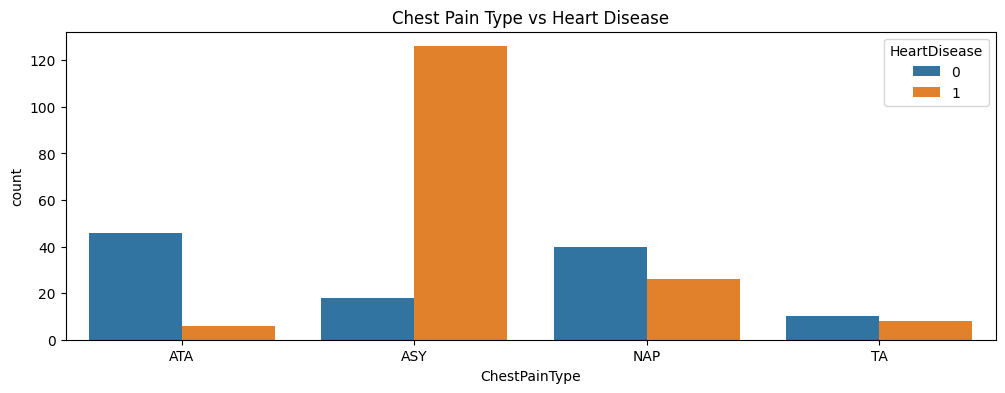

In [17]:
# countplot to visualize the distribution of categorical features
plt.figure(figsize=(12,4),dpi=100)
sns.countplot(x='ChestPainType', data=df, hue='HeartDisease')
plt.title('Chest Pain Type vs Heart Disease')
plt.show()

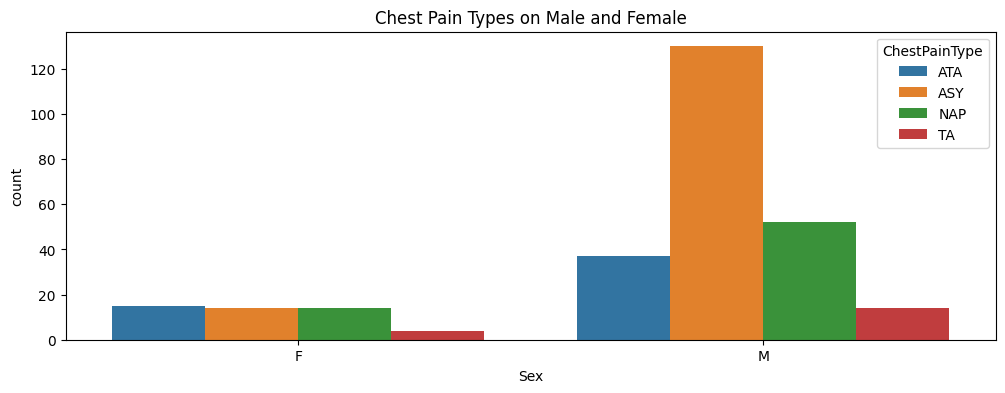

In [18]:
plt.figure(figsize=(12,4),dpi=100)
sns.countplot(x='Sex', data = df, hue='ChestPainType')
plt.title('Chest Pain Types on Male and Female')
plt.show()

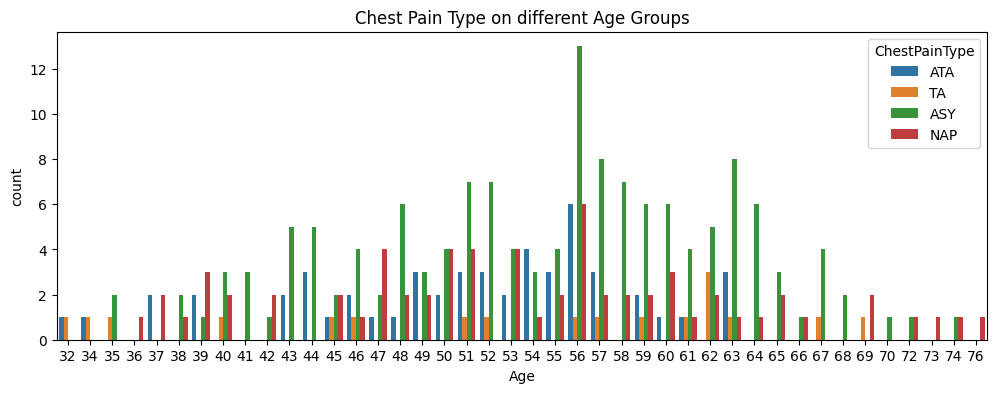

In [19]:
plt.figure(figsize=(12,4),dpi=100)
sns.countplot(x='Age', data=df, hue='ChestPainType')
plt.title('Chest Pain Type on different Age Groups')
plt.show()

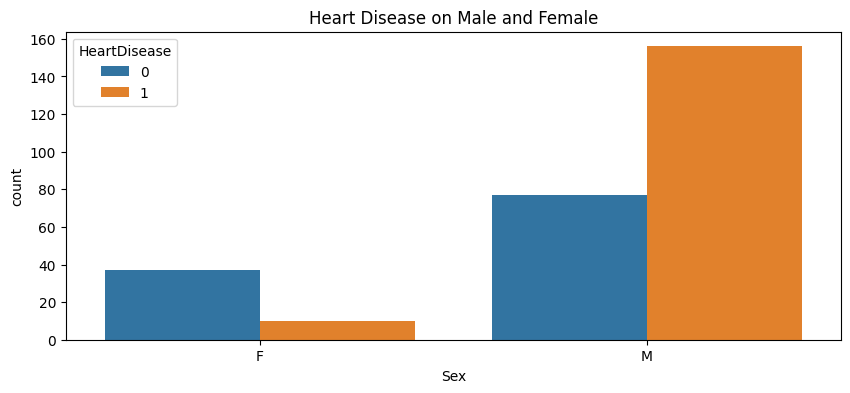

In [20]:
plt.figure(figsize=(10,4),dpi=100)
sns.countplot(x='Sex', data=df, hue='HeartDisease')
plt.title('Heart Disease on Male and Female')
plt.show()

<Figure size 1500x1000 with 0 Axes>

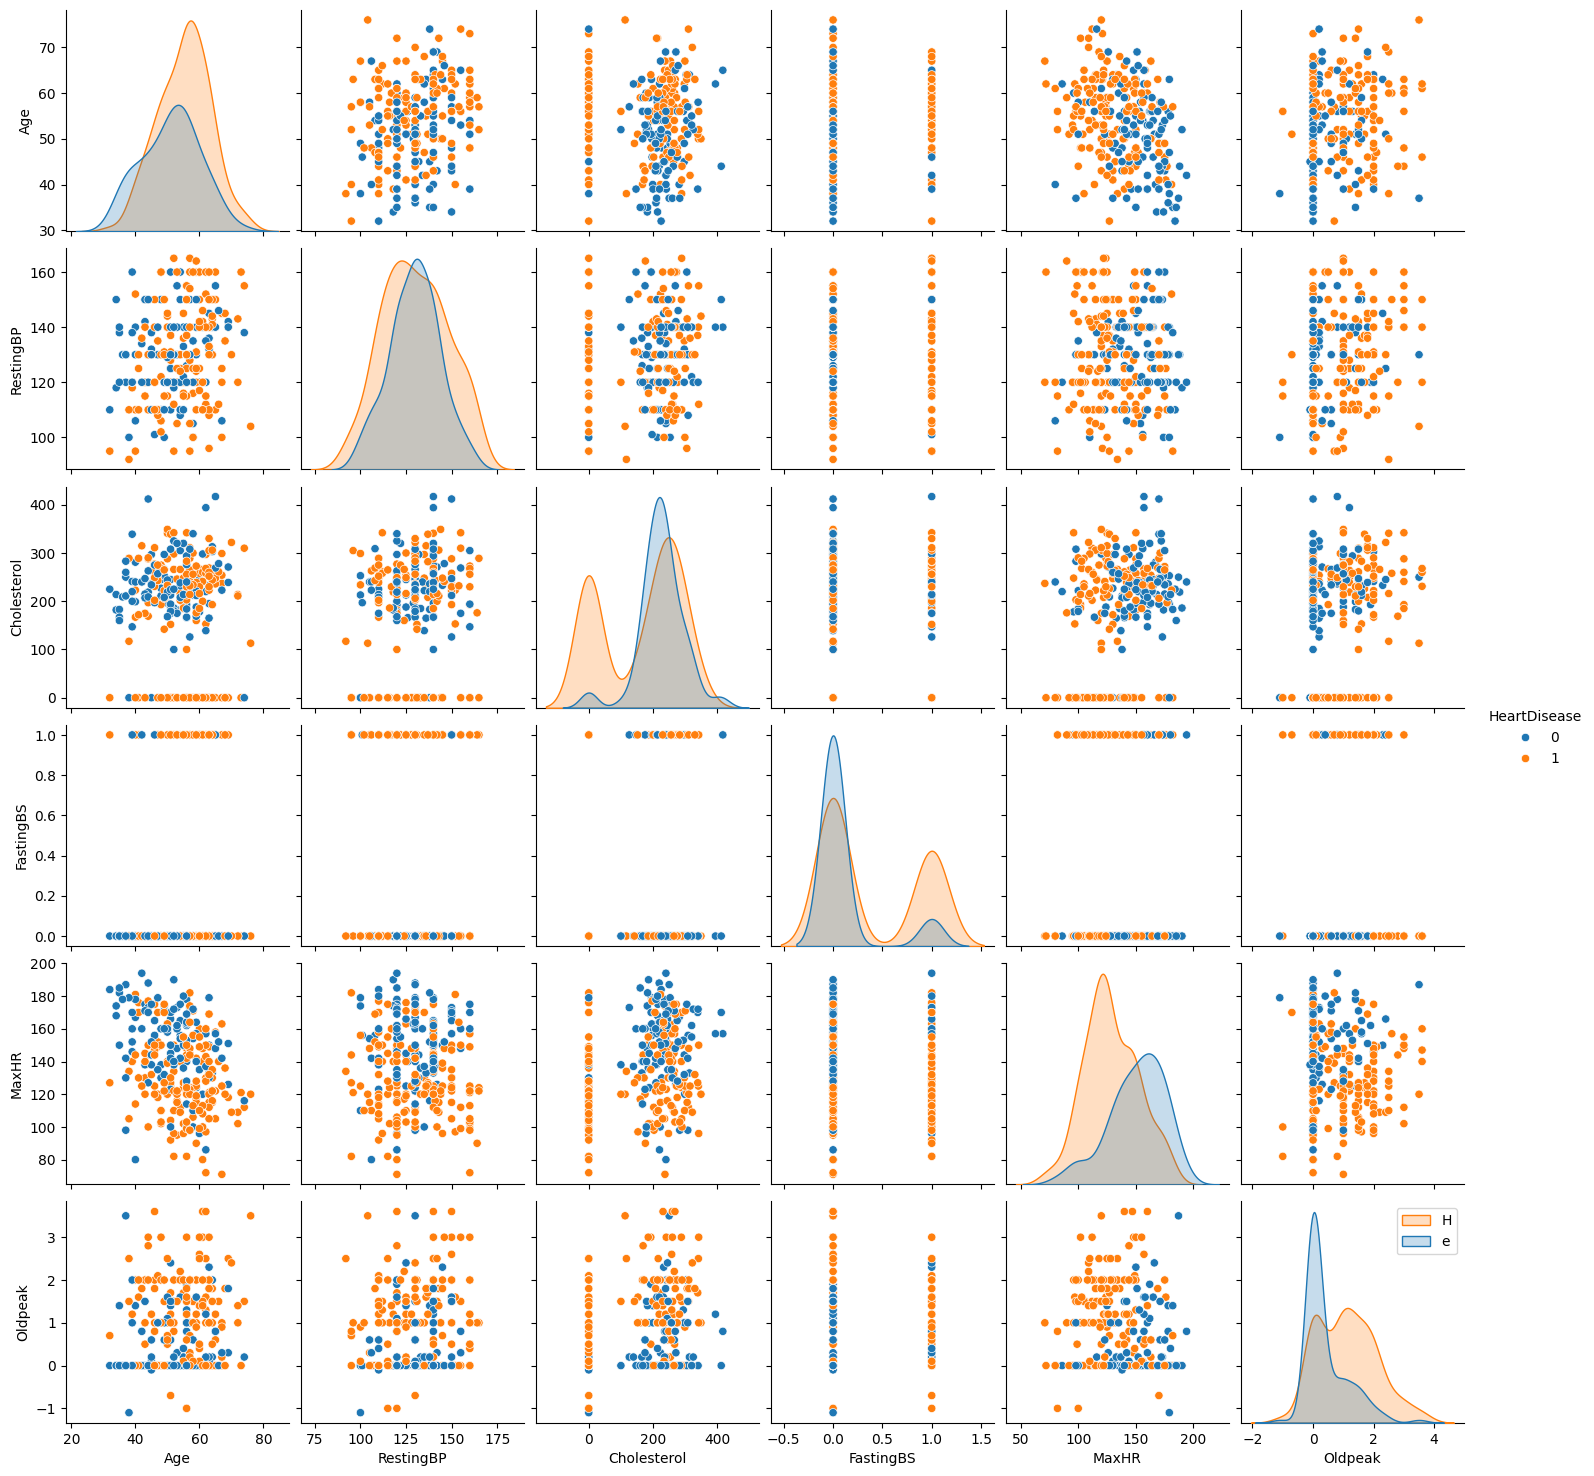

In [21]:
# Pair plot: It shows the relationship between numerical features and also shows the distribution and relationship of each numerical columns between each combination.
plt.figure(figsize=(15,10))
sns.pairplot(df, hue='HeartDisease')
plt.legend('HeartDisease')
plt.show()

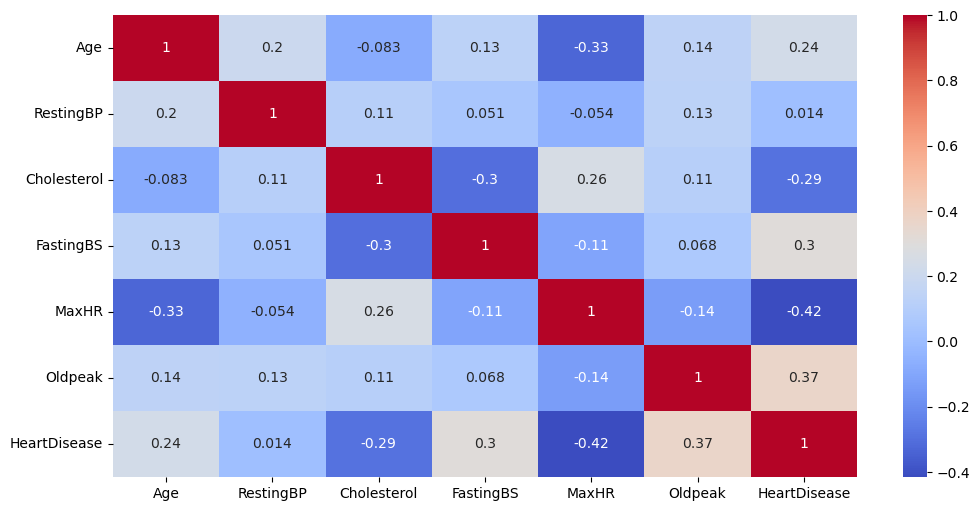

In [57]:
#correlation heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

# Data Preprocessing

In [81]:
from sklearn.preprocessing import LabelEncoder

# Separate categorical and numerical columns
cate_df = df[['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']]
num_df = df.drop(columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])

# One-hot encoding for nominal categorical columns
df_cate_dummy = pd.get_dummies(cate_df, columns=['ChestPainType', 'RestingECG', 'ST_Slope'], drop_first=True)

# Ordinal encoding for ordinal categorical columns
label_encoder = LabelEncoder()
df_cate_dummy['Sex'] = label_encoder.fit_transform(cate_df['Sex'])  # Male: 1, Female: 0
df_cate_dummy['ExerciseAngina'] = label_encoder.fit_transform(cate_df['ExerciseAngina'])  # Yes: 1, No: 0

# Combine encoded categorical columns with numerical columns
df_processed = pd.concat([num_df, df_cate_dummy], axis=1)

# Display the final preprocessed dataset
df_processed.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex,ExerciseAngina,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
668,63,140,195,0,179,0.0,0,0,0,True,False,False,True,False,False,True
377,65,160,0,1,122,1.2,1,1,0,False,False,False,False,True,True,False
535,56,130,0,0,122,1.0,1,1,1,False,False,False,False,False,True,False
807,54,108,309,0,156,0.0,0,1,0,True,False,False,True,False,False,True
793,67,125,254,1,163,0.2,1,1,0,False,False,False,True,False,True,False


In [82]:
# Convert boolean columns to integers
df_processed = df_processed.astype(int)
df_processed.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex,ExerciseAngina,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
668,63,140,195,0,179,0,0,0,0,1,0,0,1,0,0,1
377,65,160,0,1,122,1,1,1,0,0,0,0,0,1,1,0
535,56,130,0,0,122,1,1,1,1,0,0,0,0,0,1,0
807,54,108,309,0,156,0,0,1,0,1,0,0,1,0,0,1
793,67,125,254,1,163,0,1,1,0,0,0,0,1,0,1,0


## Model Development

In [97]:
X = df_processed.drop('HeartDisease', axis=1)
y = df_processed['HeartDisease']

from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

#  Feature Scaling: Standardization(StandardScaler) is used to scale the data to have a mean of 0 and a variance of 1
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [114]:
X.shape

(280, 15)

In [115]:
X_train.shape

(224, 15)

## Build the Quantum Circuit

**Variational Quantum Classifier (VQC)** from Qiskit

The Variational Quantum Classifier (VQC) is a quantum machine learning algorithm implemented in Qiskit, designed to classify data using a hybrid quantum-classical approach.

1. Hybrid Quantum-Classical Approach:

- VQC combines classical machine learning techniques with quantum computing. It uses a quantum circuit to represent a model and classical optimization techniques to train that model.
- The quantum circuit is parameterized, meaning it has adjustable parameters that can be tuned to minimize a loss function.

2. Quantum Circuits:

- The VQC uses quantum circuits to encode the input data into quantum states. These circuits can be designed using various quantum gates and can represent complex functions.
- The parameters of the quantum circuit are adjusted during training to improve classification accuracy.

3. Loss Function:

- The VQC typically uses a loss function (e.g., cross-entropy loss) to measure how well the model is performing. The goal is to minimize this loss function through optimization.

4. Optimization:

- Classical optimization algorithms (like COBYLA, SPSA, or gradient descent) are used to adjust the parameters of the quantum circuit based on the loss function's output.
- The optimization process involves running the quantum circuit multiple times to evaluate the loss and update the parameters accordingly.

5. Output:

- After training, the VQC can classify new data points by encoding them into quantum states and running the trained quantum circuit to obtain predictions.

**Key Components of VQC**  

a) Feature Map: A quantum circuit that encodes classical data into quantum states. It transforms the input features into a form suitable for quantum processing.      

b) Ansatz: A parameterized quantum circuit that represents the model. The ansatz can be designed in various ways, depending on the problem and the desired complexity.  

c) Quantum Instance: Represents the quantum backend (simulator or real quantum device) on which the quantum circuit is executed.


In [116]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer
# Step : Encode the target labels as one-hot vectors
encoder = LabelBinarizer()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

In [117]:
# Set a random seed for reproducibility
algorithm_globals.random_seed = 42

## 1. DEFINE THE FEATURE MAP

# Define the feature map with unique parameter names
num_features = X_train.shape[1]
feature_params = ParameterVector("x", num_features)  # Use "x" for feature map parameters

from qiskit.circuit.library import ZZFeatureMap
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)

#feature_map = TwoLocal(
 #   num_qubits=num_features,
  #  reps=2,
   # rotation_blocks=["ry", "rz"],
    #entanglement="full",
    #parameter_prefix="x",  # Unique prefix for feature map parameters
#)


In [118]:
## 2. DEFINE THE ANSATZ

# Define the ansatz with unique parameter names
ansatz_params = ParameterVector("θ", num_features)  # Use "θ" for ansatz parameters
ansatz = TwoLocal(
    num_qubits=num_features,
    reps=1,
    rotation_blocks=["ry", "rz"],
    entanglement="circular",#full
    parameter_prefix="θ",  # Unique prefix for ansatz parameters
)

In [119]:
from qiskit.algorithms.optimizers import COBYLA  # Import the optimizer

In [136]:
## 3. DEFINE THE VQC MODEL


# Define the sampler
sampler = Sampler()

# Build the quantum neural network (QNN)
qnn = SamplerQNN(
    sampler=sampler,
    circuit=feature_map.compose(ansatz),
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    input_gradients=False,
)

# Define the VQC model
vqc = NeuralNetworkClassifier(
    neural_network=qnn,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=50),
    one_hot=False,  # Disable one-hot encoding (requires binary labels)
    initial_point=algorithm_globals.random.random(ansatz.num_parameters),
)

In [137]:
# Train the model
vqc.fit(X_train, y_train)

KeyError: 0

In [134]:
# Ensure X_train and y_train_encoded are NumPy arrays
X_train = X_train.values if hasattr(X_train, 'values') else X_train
y_train_encoded = y_train_encoded.values if hasattr(y_train_encoded, 'values') else y_train_encoded

In [135]:
# Ensure X_train and y_train_encoded are NumPy arrays
#X_train = X_train if isinstance(X_train, np.ndarray) else np.array(X_train)
#y_train_encoded = y_train_encoded if isinstance(y_train_encoded, np.ndarray) else np.array(y_train_encoded)


# Train the model
vqc.fit(X_train, y_train)
y_pred_encoded = vqc.predict(X_test)
y_pred = encoder.inverse_transform(y_pred_encoded)  # Convert back to original labels
#accuracy = accuracy_score(y_test, y_pred)
#print(f"VQC Accuracy: {accuracy * 100:.2f}%")

KeyError: 0